In [1]:
# IMPORT STATEMENTS

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

In [3]:
# Execute the preprocessing notebook first
%run PREPROCESSING_ALGO_RHYTHM.ipynb

ModuleNotFoundError: No module named 'google.colab'

ModuleNotFoundError: No module named 'google.colab'

### ML SECTION ###

In [6]:
# Keep only the final selected features
X_final = X[final_features].copy()

print("X_final shape:", X_final.shape)
print("Columns in X_final:")
print(X_final.columns.tolist())


X_final shape: (1946, 20)
Columns in X_final:
['SAT_AVG_ALL', 'INEXPFTE', 'ENDOWBEGIN', 'AVGFACSAL', 'TUITIONFEE_IN', 'TUITFTE', 'NPT4_75UP_PRIV', 'UGDS_ASIAN', 'ROOMBOARD_ON', 'IRPS_NRA', 'UGDS_NRA', 'NPT41_PRIV', 'PCTFLOAN', 'CCUGPROF', 'PCTPELL', 'PFTFTUG1_EF', 'STUFACR', 'ROOMBOARD_OFF', 'UGDS_2MOR', 'PPLUS_PCT_HIGH_POOLED_SUPP']


In [8]:
# Train/test split
from sklearn.model_selection import train_test_split

# Restrict to final selected features
X_final = X[final_features].copy()

# Everything is numeric now
NUMERIC_FEATURES = list(X_final.columns)
CATEGORICAL_FEATURES = []   # <- empty on purpose

print("Numeric features:", NUMERIC_FEATURES)
print("Categorical features:", CATEGORICAL_FEATURES)



X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

# Class balance check
train_class_distribution = y_train.value_counts(normalize=True) * 100
print("\n--- Class Distribution in Training Data (y_train) ---")
print(f"Non-Selective (0): {train_class_distribution.loc[0]:.2f}%")
print(f"Highly Selective (1): {train_class_distribution.loc[1]:.2f}%")

# Numeric-only preprocessor
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES),
        # no categorical block needed
    ],
    remainder="drop"
)

print("\nPreprocessor defined with numeric-only transformations.")


Numeric features: ['SAT_AVG_ALL', 'INEXPFTE', 'ENDOWBEGIN', 'AVGFACSAL', 'TUITIONFEE_IN', 'TUITFTE', 'NPT4_75UP_PRIV', 'UGDS_ASIAN', 'ROOMBOARD_ON', 'IRPS_NRA', 'UGDS_NRA', 'NPT41_PRIV', 'PCTFLOAN', 'CCUGPROF', 'PCTPELL', 'PFTFTUG1_EF', 'STUFACR', 'ROOMBOARD_OFF', 'UGDS_2MOR', 'PPLUS_PCT_HIGH_POOLED_SUPP']
Categorical features: []
X_train shape: (1362, 20)
X_test shape:  (584, 20)

--- Class Distribution in Training Data (y_train) ---
Non-Selective (0): 94.49%
Highly Selective (1): 5.51%

Preprocessor defined with numeric-only transformations.


In [9]:
# 4) Build Baselines: Compare Models (minimum 2; 3 recommended).
# Baseline 1: Logistic Regression (Optimization-based, requires scaling)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Baseline 2: k-Nearest Neighbors (Distance-based, critically requires scaling)
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Baseline 3: Decision Tree (Non-parametric, does not require scaling, but uses preprocessed data)
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Store pipelines for iteration
pipelines = {
    'Logistic Regression': lr_pipeline,
    'kNN (k=5)': knn_pipeline,
    'Decision Tree': dt_pipeline
}



--- Starting 5-Fold Stratified Cross-Validation on X_train ---

Evaluating: Logistic Regression...

Evaluating: kNN (k=5)...

Evaluating: Decision Tree...


/tmp/ipython-input-2475270035.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['ROC AUC Mean'], palette='Blues')



--- Baseline Model Comparison (Mean CV Scores) ---
                     Accuracy Mean  Accuracy Std  ROC AUC Mean
Logistic Regression         0.9648        0.0068        0.8676
kNN (k=5)                   0.9699        0.0036        0.8433
Decision Tree               0.9567        0.0058        0.7825


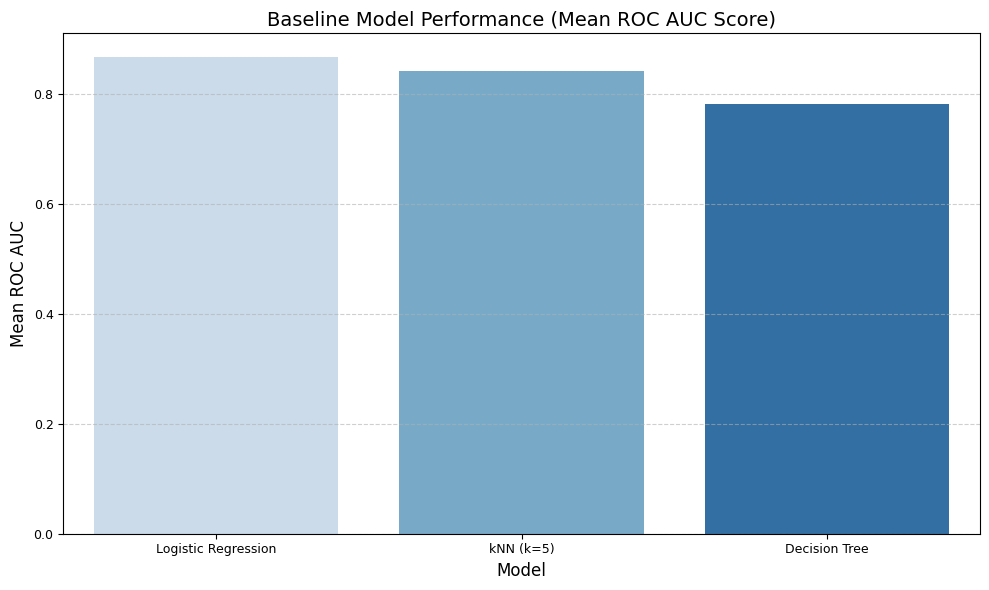

In [10]:
import numpy as np
# Perform Cross-Validation for Baseline Comparison

# Before proceeding, ensure that NUMERIC_FEATURES in X_train and X_test are purely numeric.
# Convert non-numeric values (like 'PS') to NaN so SimpleImputer can handle them.
for col in NUMERIC_FEATURES:
    if col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    if col in X_test.columns:
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')


# Define a stratified CV strategy for robust scoring
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = {}
metrics = ['accuracy', 'roc_auc'] # Use key classification metrics

print("\n--- Starting 5-Fold Stratified Cross-Validation on X_train ---")

for name, pipe in pipelines.items():
    print(f"\nEvaluating: {name}...")

    # Calculate Mean Accuracy
    accuracy_scores = cross_val_score(pipe, X_train, y_train, cv=cv_strategy, scoring='accuracy', n_jobs=-1)

    # Calculate Mean ROC AUC (a better measure for imbalanced data)
    roc_auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

    results[name] = {
        'Accuracy Mean': np.mean(accuracy_scores),
        'Accuracy Std': np.std(accuracy_scores),
        'ROC AUC Mean': np.mean(roc_auc_scores)
    }

# Report Baseline Results

# Convert results dictionary to a clean DataFrame for reporting
results_df = pd.DataFrame(results).T.sort_values(by='ROC AUC Mean', ascending=False)

print("\n--- Baseline Model Comparison (Mean CV Scores) ---")
print(results_df.round(4))

# Optional: Plotting results
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['ROC AUC Mean'], palette='Blues')
plt.title('Baseline Model Performance (Mean ROC AUC Score)', fontsize=14)
plt.ylabel('Mean ROC AUC', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0     0.9769    0.9964    0.9865       552
           1     0.9048    0.5938    0.7170        32

    accuracy                         0.9743       584
   macro avg     0.9408    0.7951    0.8518       584
weighted avg     0.9730    0.9743    0.9718       584



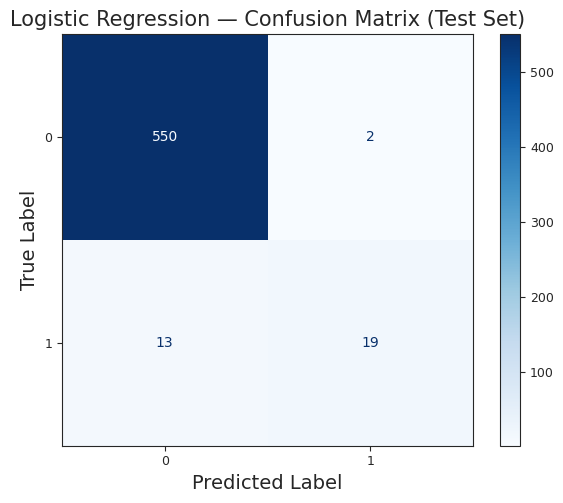

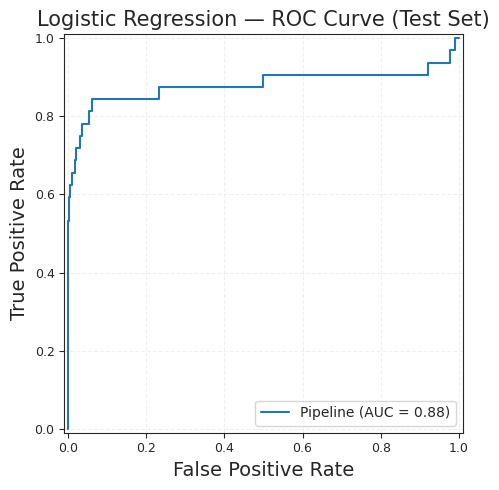

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib

# ----------------------------
# GLOBAL FONT SETTINGS
# ----------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

sns.set_style("ticks")

# Helper: force Times New Roman on all text in a figure
def force_times_new_roman(fig):
    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontname("Times New Roman")
        # also force for text inside heatmap
        for child in ax.get_children():
            if isinstance(child, matplotlib.text.Text):
                child.set_fontname("Times New Roman")


# ----------------------------
# FINAL EVALUATION
# ----------------------------

best_model_name = results_df.index[0]
best_pipeline = pipelines[best_model_name]
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred, digits=4))


# ----------------------------
# CONFUSION MATRIX
# ----------------------------
fig, ax = plt.subplots(figsize=(6,5))

disp = ConfusionMatrixDisplay.from_estimator(
    best_pipeline,
    X_test,
    y_test,
    cmap="Blues",
    ax=ax
)

ax.set_title(f"{best_model_name} — Confusion Matrix (Test Set)", fontsize=15)
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)

force_times_new_roman(fig)
plt.tight_layout()
plt.show()


# ----------------------------
# ROC CURVE
# ----------------------------
fig, ax = plt.subplots(figsize=(6,5))

RocCurveDisplay.from_estimator(
    best_pipeline,
    X_test,
    y_test,
    ax=ax
)

ax.set_title(f"{best_model_name} — ROC Curve (Test Set)", fontsize=15)
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.grid(alpha=0.3, linestyle="--")

force_times_new_roman(fig)
plt.tight_layout()
plt.show()




/var/folders/fv/pr21mymd1v1882t5qyschcx00000gn/T/ipykernel_80215/2102682576.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


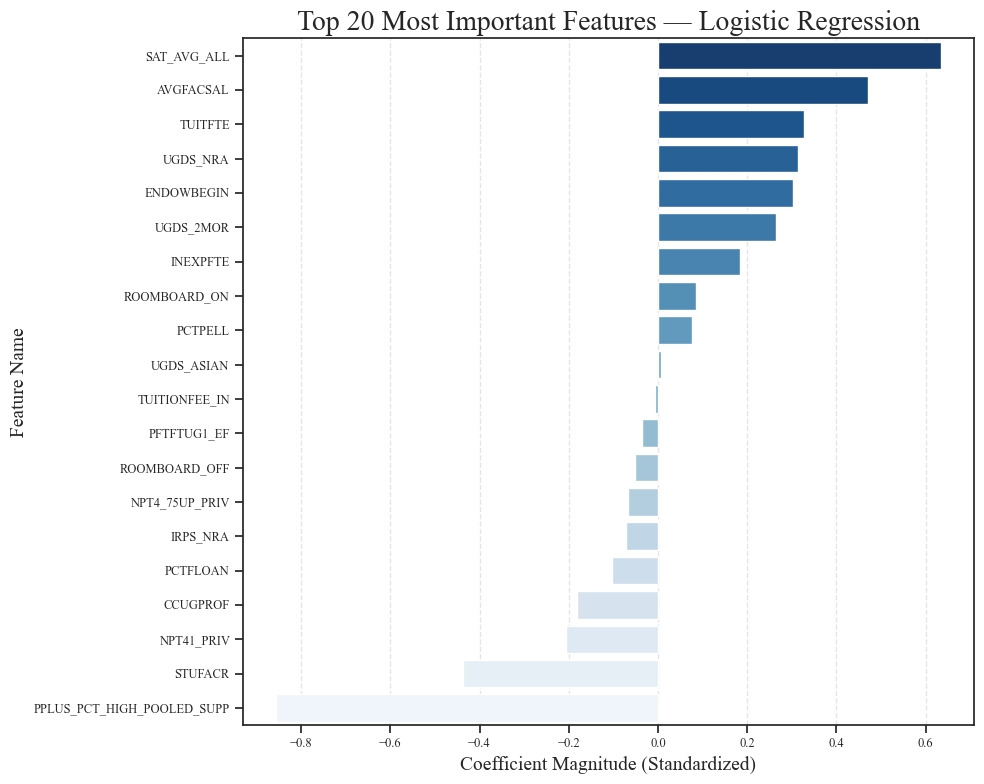

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# ----------------------------
# GLOBAL FONT SETTINGS
# ----------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

sns.set_style("ticks")

# Helper: force Times New Roman on all text in a figure
def force_times_new_roman(fig):
    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontname("Times New Roman")

        # also fix bar labels, text children, etc.
        for child in ax.get_children():
            if isinstance(child, matplotlib.text.Text):
                child.set_fontname("Times New Roman")


# ----------------------------
# IMPORTANCE PLOT
# ----------------------------

# 1. Model coefficients
coeffs = best_pipeline.named_steps['classifier'].coef_[0]

# 2. Feature names
final_features = X_train.columns

# 3. Convert to Series
coef_series = pd.Series(coeffs, index=final_features)

# 4. Top 20 by magnitude
top = coef_series.sort_values(ascending=False).head(20)

# ----------------------------
# PLOT
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    x=top.values,
    y=top.index,
    palette="Blues_r",
    ax=ax
)

ax.set_title("Top 20 Most Important Features — Logistic Regression",
             fontsize=20, fontname="Times New Roman")
ax.set_xlabel("Coefficient Magnitude (Standardized)",
              fontsize=14, fontname="Times New Roman")
ax.set_ylabel("Feature Name",
              fontsize=14, fontname="Times New Roman")

ax.grid(axis="x", linestyle="--", alpha=0.5)

# Apply the text fix
force_times_new_roman(fig)

plt.tight_layout()
plt.show()


### FIGURES FOR EXPLAINING FEATURES - NOT EDITED YET ###

In [ ]:
df_eda = df_temp.copy()
df_eda['SAT_AVG_ALL'] = df_eda['SAT_AVG_ALL'].fillna(df_eda['SAT_AVG_ALL'].median())
df_eda['UGDS_WHITE']  = df_eda['UGDS_WHITE'].fillna(df_eda['UGDS_WHITE'].median())
df_eda['PCTPELL']     = df_eda['PCTPELL'].fillna(df_eda['PCTPELL'].median())
df_eda['TUITIONFEE_IN'] = df_eda['TUITIONFEE_IN'].fillna(df_eda['TUITIONFEE_IN'].median())


NameError: name 'df_temp' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Combine X and y for plotting
df_plot = pd.concat([X.copy(), y.rename("IS_SELECTIVE")], axis=1)

# Human-readable target label
df_plot["IS_SELECTIVE_LABEL"] = df_plot["IS_SELECTIVE"].map({
    1: "Highly Selective (1)",
    0: "Other Schools (0)"
})

# Optional: global style (Times New Roman, light grid)
plt.rcParams.update({
    "font.family": "Times New Roman",
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})
sns.set_style("whitegrid")


/var/folders/fv/pr21mymd1v1882t5qyschcx00000gn/T/ipykernel_17950/2599215275.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


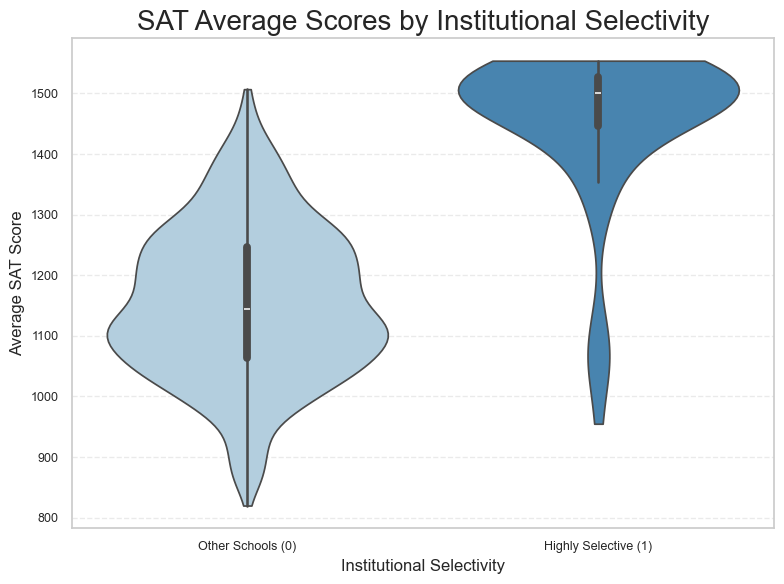

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---- GLOBAL STYLE ----
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 20,
    "axes.labelsize": 12,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})
sns.set_style("whitegrid")

# ---- CLEANED DATAFRAME FOR VISUALS ----
df_plot_clean = df_plot.copy()

# ---- PREPARE SAT DF ----
df_sat = df_plot_clean[["SAT_AVG_ALL", "IS_SELECTIVE"]].copy()
df_sat = df_sat[df_sat["SAT_AVG_ALL"] > 400]
df_sat["IS_SELECTIVE_LABEL"] = df_sat["IS_SELECTIVE"].map({
    0: "Other Schools (0)",
    1: "Highly Selective (1)"
})

# ---- VIOLIN + BOX ----
plt.figure(figsize=(8, 6))

sns.violinplot(
    data=df_sat,
    x="IS_SELECTIVE_LABEL",
    y="SAT_AVG_ALL",
    palette=sns.color_palette("Blues", n_colors=2),
    inner="box",
    cut=0
)

plt.title("SAT Average Scores by Institutional Selectivity")
plt.xlabel("Institutional Selectivity")
plt.ylabel("Average SAT Score")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np

# ------------ CONFIG ------------
# Threshold for “low” SAT for highly selective schools
LOW_SAT_THRESHOLD = 1300    # you can change to 1200, 1100, etc.

# ------------ PREPARE DATA ------------
# Combine school SAT scores and selectiveness
df_sat_check = pd.concat([
    df.copy(),
    y.rename("IS_SELECTIVE")
], axis=1)

# Ensure SAT column exists
if "SAT_AVG_ALL" not in df_sat_check.columns:
    raise ValueError("SAT_AVG_ALL not found in X. Check your column names.")

# Clean SAT values
df_sat_check = df_sat_check[df_sat_check["SAT_AVG_ALL"].between(400, 1600, inclusive="both")]

# Keep only highly selective schools
df_selective = df_sat_check[df_sat_check["IS_SELECTIVE"] == 1]

# Filter for low SAT among selective schools
df_weird_selective = df_selective[df_selective["SAT_AVG_ALL"] < LOW_SAT_THRESHOLD]

# Sort ascending (lowest SAT at top)
df_weird_selective = df_weird_selective.sort_values("SAT_AVG_ALL")

cols_to_show = ["INSTNM", "SAT_AVG_ALL", "IS_SELECTIVE"]
df_weird_selective[cols_to_show]

,INSTNM,SAT_AVG_ALL,IS_SELECTIVE
1228,Grambling State University,955.0,1.0
1631,Alcorn State University,1039.0,1.0
5183,DeVry University-Texas,1050.0,1.0
593,Johnson University Florida,1060.0,1.0
604,Florida Agricultural and Mechanical University,1100.0,1.0
1730,College of the Ozarks,1125.0,1.0
559,United States Coast Guard Academy,1290.0,1.0


/var/folders/fv/pr21mymd1v1882t5qyschcx00000gn/T/ipykernel_17950/3151472424.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


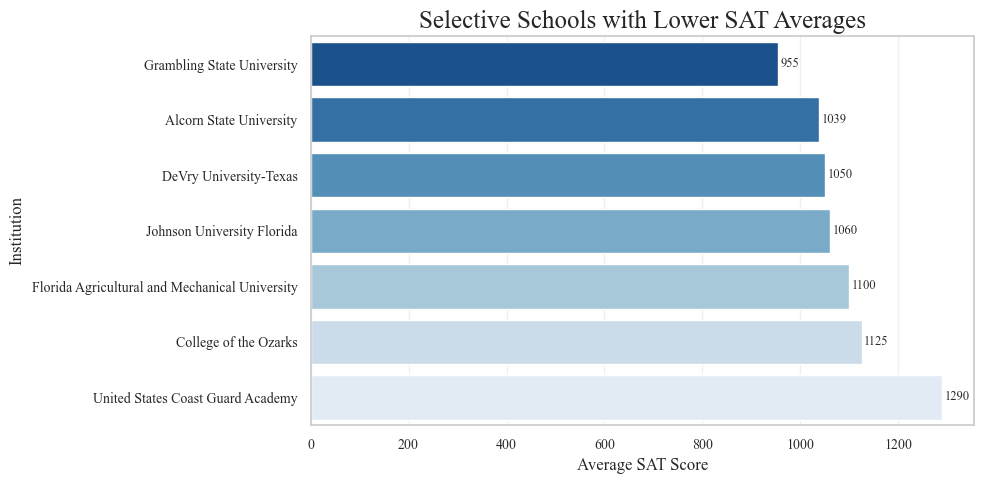

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Times New Roman global style ----
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 18,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Make a copy and sort by SAT for nicer plotting
plot_df = df_weird_selective.copy().sort_values("SAT_AVG_ALL")

plt.figure(figsize=(10, 5))

sns.barplot(
    data=plot_df,
    x="SAT_AVG_ALL",
    y="INSTNM",
    palette="Blues_r"
)

plt.title("Selective Schools with Lower SAT Averages")
plt.xlabel("Average SAT Score")
plt.ylabel("Institution")

# Optional: add exact values on bars
for i, (sat_val) in enumerate(plot_df["SAT_AVG_ALL"]):
    plt.text(
        sat_val + 5,      # a little to the right of the bar
        i,
        f"{sat_val:.0f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()


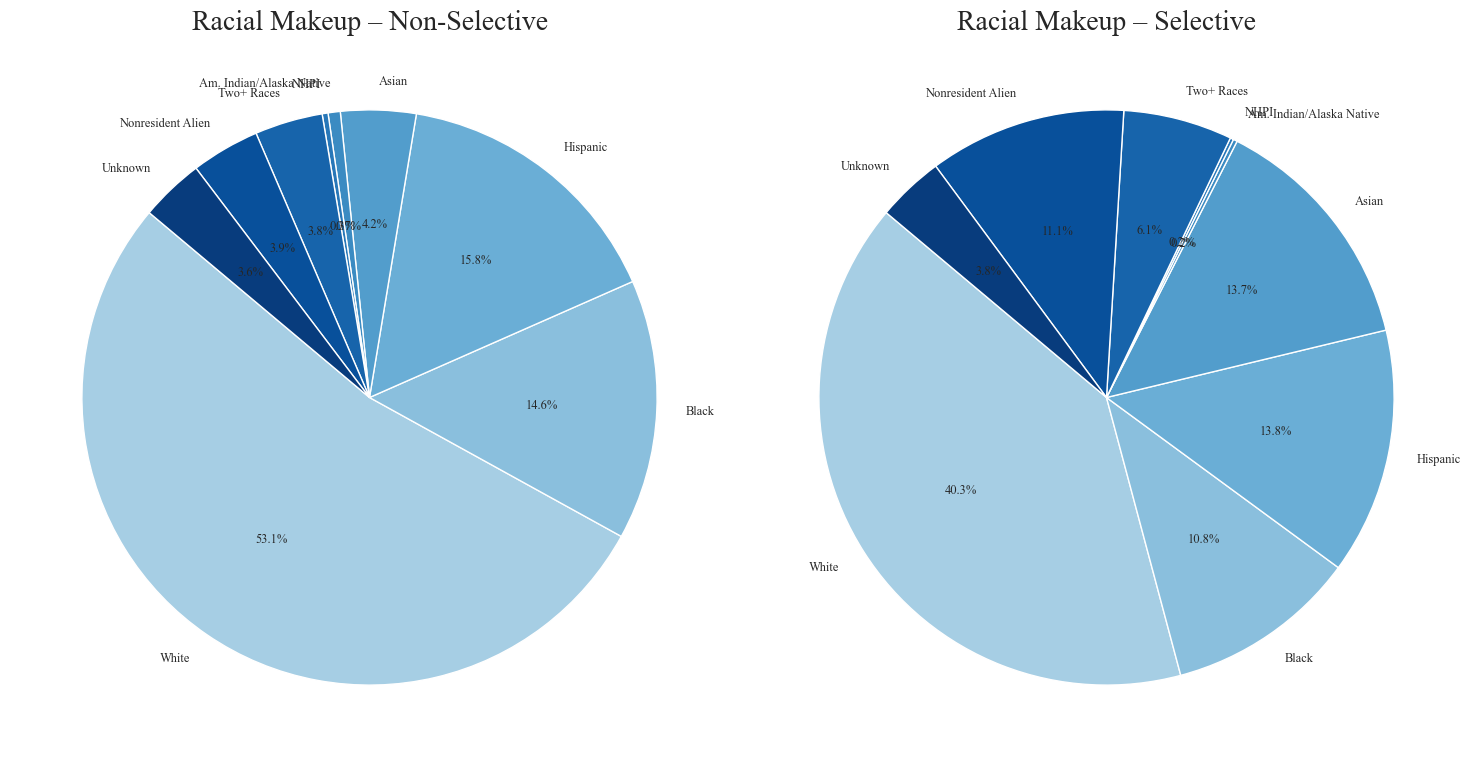

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Global Times New Roman style ----
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 20,
    "axes.labelsize": 12,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# Racial columns
race_cols = [
    "UGDS_WHITE", "UGDS_BLACK", "UGDS_HISP", "UGDS_ASIAN",
    "UGDS_AIAN", "UGDS_NHPI", "UGDS_2MOR", "UGDS_NRA", "UGDS_UNKN"
]

df_race = pd.concat([X[race_cols], y.rename("IS_SELECTIVE")], axis=1)
df_race["Group"] = df_race["IS_SELECTIVE"].map({
    1: "Highly Selective (1)",
    0: "Other Schools (0)"
})

# Means by group
selective_mean = df_race[df_race["Group"] == "Highly Selective (1)"][race_cols].mean()
other_mean     = df_race[df_race["Group"] == "Other Schools (0)"][race_cols].mean()

# Normalize each pie to sum to 1
selective_mean /= selective_mean.sum()
other_mean     /= other_mean.sum()

pretty_labels = [
    "White", "Black", "Hispanic", "Asian",
    "Am. Indian/Alaska Native", "NHPI",
    "Two+ Races", "Nonresident Alien", "Unknown"
]

# ---- Blues palette: generate 9 evenly spaced blue shades ----
num_slices = len(pretty_labels)
colors = plt.cm.Blues(np.linspace(0.35, 0.95, num_slices))

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Pie 1 — Other Schools
axes[0].pie(
    other_mean.values,
    labels=pretty_labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    textprops={"fontsize": 9}
)
axes[0].set_title("Racial Makeup – Non-Selective")

# Pie 2 — Highly Selective Schools
axes[1].pie(
    selective_mean.values,
    labels=pretty_labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    textprops={"fontsize": 9}
)
axes[1].set_title("Racial Makeup – Selective")

plt.tight_layout()
plt.show()



### FEATURE SELECTION ###

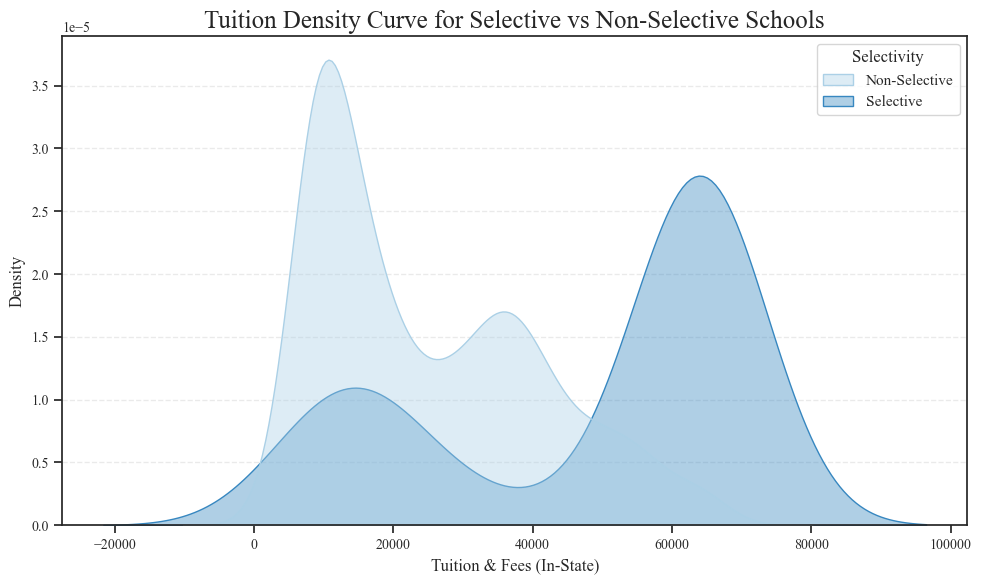

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======== GLOBAL STYLE (Times New Roman) ========
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 18,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# -------------------------------------------
# Prepare the data
# -------------------------------------------
df_tuition = pd.concat(
    [X[["TUITIONFEE_IN"]], y.rename("IS_SELECTIVE")],
    axis=1
).dropna(subset=["TUITIONFEE_IN", "IS_SELECTIVE"])

df_tuition["Selectivity"] = df_tuition["IS_SELECTIVE"].map({
    1: "Selective",
    0: "Non-Selective"
})
# -------------------------------------------
# Density (KDE) Plot — cleaner comparison
# -------------------------------------------
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_tuition,
    x="TUITIONFEE_IN",
    hue="Selectivity",
    fill=True,
    common_norm=False,
    alpha=0.4,
    palette="Blues"
)

plt.title("Tuition Density Curve for Selective vs Non-Selective Schools")
plt.xlabel("Tuition & Fees (In-State)")
plt.ylabel("Density")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


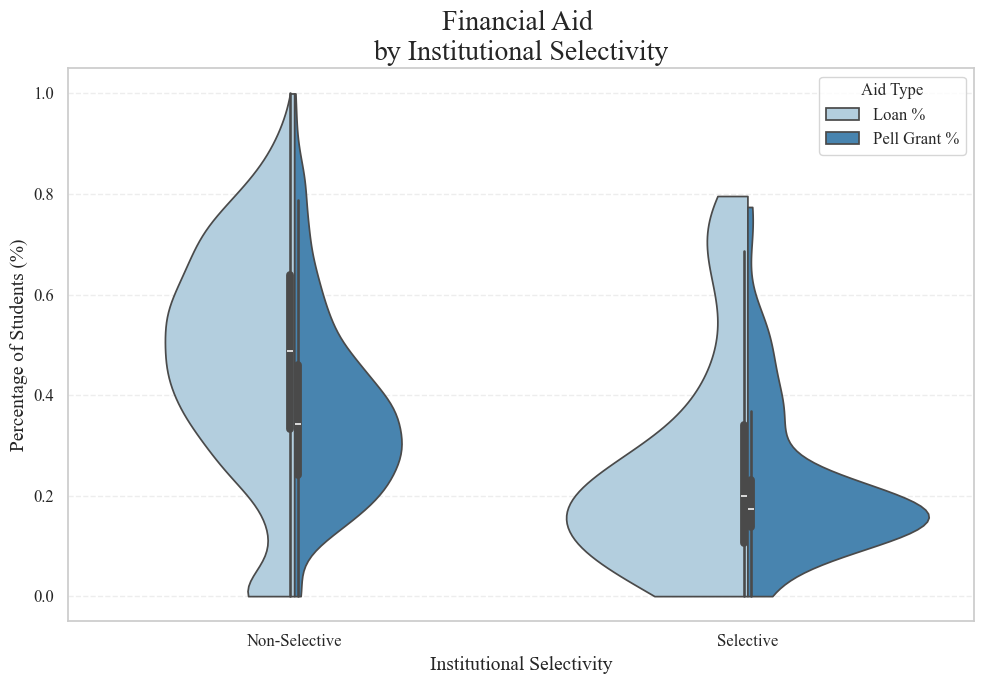

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# =============================
# FORCE TIMES NEW ROMAN GLOBAL
# =============================

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 20,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

sns.set_style("whitegrid")

# EXTRA: Force legend & all text objects to TNR as fallback
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.title_fontsize'] = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']


# =============================
# Prepare dataset
# =============================

df_plot = pd.concat([X[["PCTPELL", "PCTFLOAN"]], y.rename("IS_SELECTIVE")], axis=1)
df_plot = df_plot.dropna(subset=["PCTPELL", "PCTFLOAN", "IS_SELECTIVE"])

df_plot["Selectivity"] = df_plot["IS_SELECTIVE"].map({
    0: "Non-Selective",
    1: "Selective"
})

df_long = df_plot.melt(
    id_vars=["Selectivity"],
    value_vars=["PCTFLOAN", "PCTPELL"],
    var_name="Aid_Type",
    value_name="Percentage"
)

df_long["Aid Type"] = df_long["Aid_Type"].map({
    "PCTFLOAN": "Loan %",
    "PCTPELL": "Pell Grant %"
})


# =============================
# Violin Plot
# =============================

plt.figure(figsize=(10, 7))

ax = sns.violinplot(
    data=df_long,
    x="Selectivity",
    y="Percentage",
    hue="Aid Type",
    palette=sns.color_palette("Blues", n_colors=2),
    split=True,
    inner="box",
    cut=0
)

# Force Times New Roman on EVERYTHING manually
for text in ax.texts:
    text.set_fontfamily("Times New Roman")

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily("Times New Roman")

ax.set_title(
    "Financial Aid \nby Institutional Selectivity",
    fontfamily="Times New Roman",
    fontsize=20
)
ax.set_xlabel("Institutional Selectivity", fontfamily="Times New Roman")
ax.set_ylabel("Percentage of Students (%)", fontfamily="Times New Roman")

# Fix legend fonts
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_fontfamily("Times New Roman")
leg.get_title().set_fontfamily("Times New Roman")

plt.grid(axis='y', linestyle='--', alpha=0.35)

plt.tight_layout()
plt.show()

